In [1]:
import spacy
import numpy as np
import pandas as pd
from collections import Counter
from wordfreq import word_frequency
import scipy
from scipy import stats
import matplotlib.pyplot as plt 

C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
header_names = ['HIT ID', 'Sentence', 'Start word', 'End word', 'Target word', 'Native', 'Non-native', 'Difficult native',
         'Difficult non', 'Binary', 'Prob']

In [4]:
tsv_data = pd.read_csv('data/original/english/WikiNews_Train.tsv', sep='\t', header = 0, names = header_names)

## 8.

In [5]:
'''
At least one native or non-native thought it was difficult
'''
temp_data = tsv_data.loc[(tsv_data["Difficult native"] >= 1) | (tsv_data["Difficult non"] >= 1)]

In [8]:
'''
Fuck pandas
'''
clean = temp_data
lengths = []
for i in range(len(temp_data)):
    if len(clean["Target word"].iloc[i].split(' ')) == 1:
        lengths.append(1)
    else:
        lengths.append(0)

clean['lengths'] = lengths

clean = clean.loc[(clean['lengths'] == 1)]

C:\Users\JWant\AppData\Local\Temp\ipykernel_19088\1724494000.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


In [9]:
'''
Calculate word length and compute correlation with probabilistic complexity
'''
wordcor = []
postags = []

for i in range(len(clean)):
    
    #pos tagging
    for token in nlp(clean['Sentence'].iloc[i]):
        if token.text ==clean['Target word'].iloc[i]:
            pos=token.pos_
            postags.append([pos, clean['Prob'].iloc[i]])
            break
                
    wordcor.append([len(clean['Target word'].iloc[i]), 
                    word_frequency(clean['Target word'].iloc[i], 'en', minimum = 0.0),
                    clean['Prob'].iloc[i]])


In [10]:
# x is word length, y is probabilistic complexity
word_length = np.array(wordcor).T[0]
word_freq = np.array(wordcor).T[1]
prob_complex = np.array(wordcor).T[2]

In [9]:
print(f"Pearson Correlation length vs complexity: {scipy.stats.pearsonr(word_length, prob_complex)[0]}, p = {scipy.stats.pearsonr(word_length, prob_complex)[1]}")
print(f"Pearson Correlation frequency vs complexity: {scipy.stats.pearsonr(word_freq, prob_complex)[0]}, p = {scipy.stats.pearsonr(word_freq, prob_complex)[1]}")

Pearson Correlation length vs complexity: 0.2818309268002792, p = 1.0076965862007542e-46
Pearson Correlation frequency vs complexity: -0.29798346346415117, p = 2.8208442174820757e-52


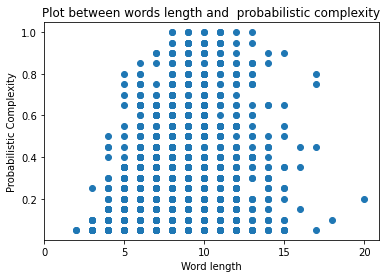

In [10]:
plt.scatter(word_length, prob_complex)
plt.title("Plot between words length and  probabilistic complexity")
plt.xlabel("Word length")
plt.ylabel("Probabilistic Complexity")
plt.xticks([0, 5, 10, 15, 20])
plt.show()

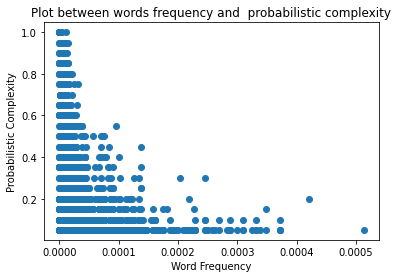

In [11]:
plt.scatter(word_freq, prob_complex)
plt.title("Plot between words frequency and  probabilistic complexity")
plt.xlabel("Word Frequency")
plt.ylabel("Probabilistic Complexity")
plt.show()

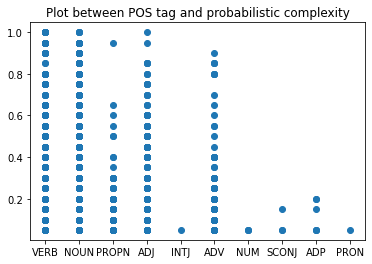

In [12]:
plt.scatter(np.array(postags).T[0], np.array(postags).T[1].astype('float'))
plt.title("Plot between POS tag and probabilistic complexity")
plt.show()

## 9. Reflection

https://www-jstor-org.vu-nl.idm.oclc.org/stable/pdf/26375812.pdf?refreqid=excelsior%3A5d2d12217d4e30d106b3a2d685c9257a&ab_segments=&origin=

We have only looked at single token linguisttic characeristics to determine complexity. However, according to the article above, complexity often arises when the word is part of a certain construct. It might therefore be useful to determine whether a word is or isn't part of such a construct.

## 10. Baselines

In [1]:
from baselines import Baseliner
import numpy as np
import matplotlib.pyplot as plt

C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
analyzer = Baseliner()
runs = 1000

### Majority Baseline

In [15]:
analyzer.set_mode("test")

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.25398633, 0.35398633, 0.45398633, 0.55398633, 0.65398633,
        0.75398633, 0.85398633, 0.95398633, 1.05398633, 1.15398633,
        1.25398633]),
 <BarContainer object of 10 artists>)

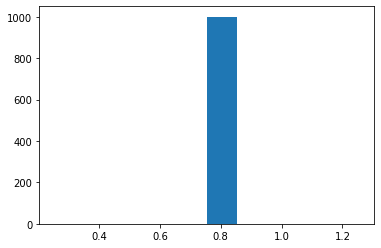

In [16]:
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.majority_baseline()[0]
plt.hist(ans)

In [12]:
np.mean(ans)

0.7539863325740317

In [18]:
analyzer.set_mode("dev")

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.30655391, 0.40655391, 0.50655391, 0.60655391, 0.70655391,
        0.80655391, 0.90655391, 1.00655391, 1.10655391, 1.20655391,
        1.30655391]),
 <BarContainer object of 10 artists>)

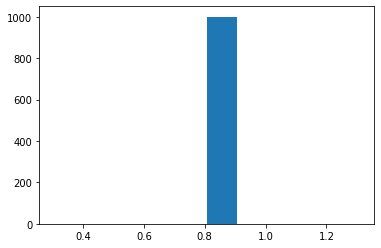

In [19]:
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.majority_baseline()[0]
plt.hist(ans)

In [20]:
np.mean(ans)

0.8065539112050737

### Random Baseliner

In [3]:
# run monte from carlo
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.random_baseline()[0]

(array([  1.,   9.,  36., 129., 212., 281., 173., 108.,  39.,  12.]),
 array([0.39635535, 0.41138952, 0.42642369, 0.44145786, 0.45649203,
        0.4715262 , 0.48656036, 0.50159453, 0.5166287 , 0.53166287,
        0.54669704]),
 <BarContainer object of 10 artists>)

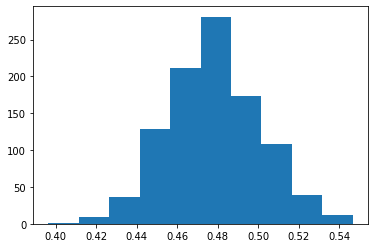

In [4]:
plt.hist(ans)

In [5]:
np.mean(ans)

0.4777699316628702

In [6]:
analyzer.set_mode("dev")

(array([  7.,  23.,  50., 118., 214., 224., 186., 109.,  56.,  13.]),
 array([0.44238901, 0.44883721, 0.45528541, 0.46173362, 0.46818182,
        0.47463002, 0.48107822, 0.48752643, 0.49397463, 0.50042283,
        0.50687104]),
 <BarContainer object of 10 artists>)

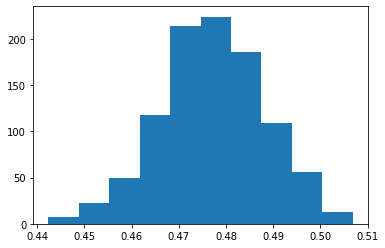

In [7]:
ans = np.zeros(runs)
for i in range(runs):
    ans[i] = analyzer.random_baseline()[0]
plt.hist(ans)

In [8]:
np.mean(ans)

0.47721828752642703

### Length Baseline

In [21]:
analyzer.set_mode("test")

In [22]:
# check for different thresholds
thresholds = [2,3,4,5,6,7,8,9,10,11,12]

In [31]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.length_baseline()[0]

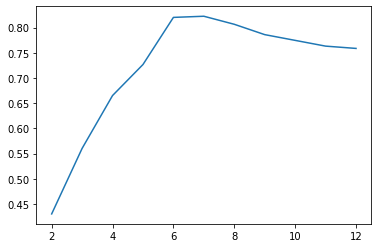

In [32]:
plt.plot(thresholds, ans)

In [33]:
np.mean(ans)

0.7194036032304824

In [35]:
analyzer.set_mode("dev")

In [36]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.length_baseline()[0]

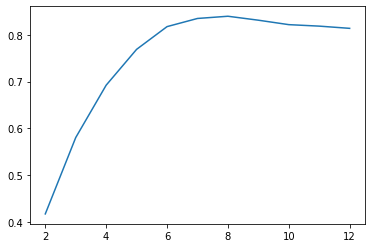

In [37]:
plt.plot(thresholds, ans)

In [39]:
np.mean(ans)

0.7488468191428023

### Frequency

In [29]:
analyzer.set_mode("test")

# check for different thresholds
thresholds = [10e-8, 10e-7, 10e-6, 10e-5,10e-4, 10e-3, 10e-2, 10e-1, 10e-0]

In [26]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.frequency_baseline()[0]

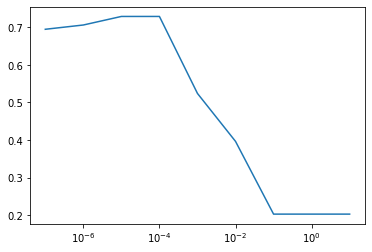

In [27]:
plt.xscale("log")
plt.plot(thresholds, ans)

In [22]:
analyzer.set_mode("dev")

# check for different thresholds
thresholds = [10e-8, 10e-7, 10e-6, 10e-5,10e-4, 10e-3, 10e-2, 10e-1, 10e-0]

In [23]:
ans = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    analyzer.threshold = threshold
    ans[i] = analyzer.frequency_baseline()[0]

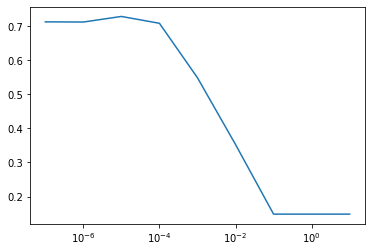

In [24]:
plt.xscale("log")
plt.plot(thresholds, ans)

In [28]:
max(ans)

0.7289293849658315